#### Importing Libraries

In [ ]:
import tensorflow as tf

print(tf.__version__)
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# running the Stanford POS Tagger from NLTK
import nltk
from nltk import word_tokenize
from nltk import StanfordTagger
import nltk
import pandas as pd
nltk.download("popular")

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from google.colab import drive
drive.mount('/content/gdrive')

!pip install tensorflow==2.2.0
import tensorflow as tf

print(tf.__version__)
!pip install keras==2.2.4
import keras
keras.__version__
#from tensorflow import keras as k
#import tensorflow as tf
!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers import CRF

from subprocess import check_output

2.2.0


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import nan
from keras.callbacks import ModelCheckpoint

!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers import CRF
from subprocess import check_output
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, GRU
import keras as k


import pandas as pd
import numpy as np

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional
from keras.models import Model, Input
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
!pip install sklearn-crfsuite
!pip install seqeval

from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import f1_score
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from keras.preprocessing.text import text_to_word_sequence
import pickle
!pip install tiny-tokenizer flair
!pip install flair

##Dataset file

In [ ]:
#dframe = dataset
from sklearn.model_selection import StratifiedKFold, KFold

cvscores = []
cvR=[]
cvF=[]
cvP=[]
i=0
kfold = StratifiedKFold(n_splits=5, shuffle=True)
words = list(dframe['words'].unique()) 
tags = list(dframe['tag'].unique()) 
target = dframe.loc[:,'tag']


# This is a class te get sentence. The each sentence will be list of tuples with its tag and pos.
class sentence(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, p, t) for w, p, t in zip(s['words'].values.tolist(),
                                                       s['POS'].values.tolist(),
                                                       s['tag'].values.tolist())] 
        self.grouped = self.df.groupby("sentence_idx").apply(agg) 
        self.sentences = [s for s in self.grouped]
        
    def get_text(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent +=1
            return s
        except:
            return None
getter = sentence(dframe) 
sentences = [" ".join([str(s[0]) for s in sent]) for sent in getter.sentences]

sent = getter.get_text()

sentences = getter.sentences

#### Defining the parameters for LSTM network

In [ ]:
# Number of data points passed in each iteration
batch_size = 50
# Passes through entire dataset
epochs = 30
# Maximum length of review
max_len = 75 
# Dimension of embedding vector
embedding = 40 
words = list(dframe['words'].unique())
tags = list(dframe['tag'].unique()) 
word_to_index = {w : i + 2 for i, w in enumerate(words)}
word_to_index["UNK"] = 1
word_to_index["PAD"] = 0

# Dictionary lable:index pair label is key and value is index.
tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
tag_to_index["PAD"] = 0
idx2word = {i: w for w, i in word_to_index.items()}
idx2tag = {i: w for w, i in tag_to_index.items()}
# Converting each sentence into list of index from list of tokens
X = [[word_to_index[w[0]] for w in s] for s in sentences]
# Padding each sequence to have same length  of each word
X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_to_index["PAD"])
y = [[tag_to_index[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen = max_len, sequences = y, padding = "post", value = tag_to_index["PAD"])
num_tag = dframe['tag'].nunique()
y = [to_categorical(i, num_classes = num_tag + 1) for i in y]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#### Bidirectional LSTM-CRF Network

In [ ]:
import keras
keras.__version__

'2.2.4'

In [ ]:
num_tags = dframe['tag'].nunique() 
# Model architecture
from keras.layers.core import Dense,Dropout,Activation,Flatten,Lambda
input = Input(shape = (max_len,))
model = Embedding(input_dim = len(words) + 2, output_dim = embedding, input_length = max_len, mask_zero = True)(input)
model = Bidirectional(GRU(units = 50, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(50, activation="relu"))(model)
#crf = Lambda(lambda x:CRF(num_tags+1))  # CRF layer
crf=CRF(num_tags+1)
out = crf(model)  

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()

checkpointer = ModelCheckpoint(filepath = 'model.h5',
                       verbose = 0,
                       mode = 'auto',
                       save_best_only = True,
                       monitor='val_loss')
history = model.fit(X_train, np.array(y_train), batch_size=batch_size, epochs=epochs,
                    validation_split=0.1, callbacks=[checkpointer])


history.history.keys()

Visualization

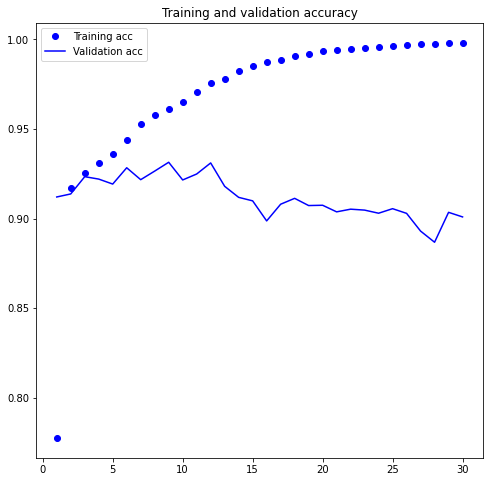

In [ ]:
acc = history.history['crf_viterbi_accuracy']
val_acc = history.history['val_crf_viterbi_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize = (8, 8))
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

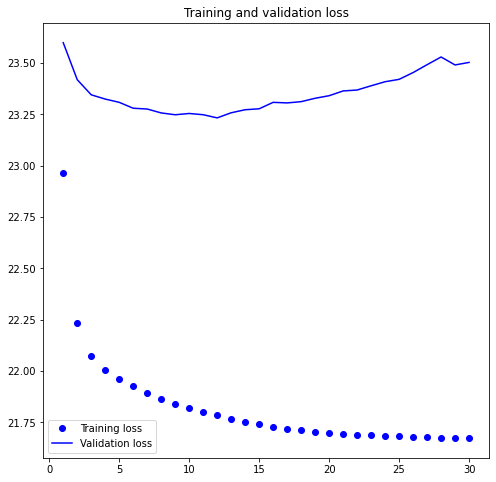

In [ ]:
plt.figure(figsize = (8, 8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Evaluating the model on test set

In [ ]:
# Evaluation
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y_test, -1)
# Convert the index to tag
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true] 

report = flat_classification_report(y_pred=y_pred, y_true=y_test_true)

# At every execution model picks some random test sample from test set.
i = np.random.randint(0,X_test.shape[0]) # choose a random number between 0 and len(X_te)b
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)

with open('word_to_index.pickle', 'wb') as f:
    pickle.dump(word_to_index, f)

with open('tag_to_index.pickle', 'wb') as f:
    pickle.dump(tag_to_index, f)

validation 

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold
cvscores = []
cvR=[]
cvF=[]
cvP=[]
i=0
kfold = StratifiedKFold(n_splits=5, shuffle=True)
words = list(dframe['words'].unique()) 
tags = list(dframe['tag'].unique()) 
target = dframe.loc[:,'tag']
epochs=10
noSents=max(dframe['sentence_idx'])-2 
a=np.array([0 for i in range(noSents)])

for trainIndex, testIndex in kfold.split(a,a):
    XTrain=np.array([X[i] for i in list(trainIndex)])
    yTrain=np.array([y[i] for i in list(trainIndex)])
    XTest=np.array([X[i] for i in list(testIndex)])
    yTest=np.array([y[i] for i in list(testIndex)])

    input = Input(shape = (max_len,))
    model = Embedding(input_dim = len(words) + 2, output_dim = embedding, input_length = max_len, mask_zero = True)(input)
    model = Bidirectional(LSTM(units = 50, return_sequences=True, recurrent_dropout=0.1))(model)
    model = TimeDistributed(Dense(50, activation="relu"))(model)
    crf=CRF(num_tags+1)  
    out = crf(model)  
    model = Model(input, out)
    model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])

    model.summary()
    checkpointer = ModelCheckpoint(filepath = 'model.h5',
                       verbose = 0,
                       mode = 'auto',
                       save_best_only = True,
                       monitor='val_loss')
    
    history = model.fit(X, np.array(y), batch_size=batch_size, epochs=epochs,
                    validation_split=0.1, callbacks=[checkpointer])
    history.history.keys()
    y_pred = model.predict(XTest)
    y_pred = np.argmax(y_pred, axis=-1)
    y_test_true = np.argmax(yTest, -1)
    y_pred = [[idx2tag[i] for i in row] for row in y_pred]
    y_test_true = [[idx2tag[i] for i in row] for row in y_test_true] 
    r=recall_score(y_test_true, y_pred)
    cvR.append(r)
    p=precision_score(y_test_true, y_pred)
    cvP.append(p)
    f=f1_score(y_test_true, y_pred)
    cvF.append(f)
    i+=1
